In [1]:
#math library for writing sq.rt
import math

In [2]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [3]:
#taking the coeff.s of the Hamiltonian from Mathematica file OneDrive-清華大學/Chi-Kwong Li/TSP/Codes/mathematica/TSL/TSL_newP_5c_withR.nb
#Also see the overleaf file for reference : https://www.overleaf.com/project/6524d9a57849dc8791655795
d = 20

l00 = d
l01 =  math.sqrt(2)
l02 =  math.sqrt(10)
l03 = 3
l10 =  math.sqrt(2)
l11 = d
l12 = 2
l13 = math.sqrt(5)
l20 = math.sqrt(10)
l21 = 2
l22 = d
l23 = 1
l30 = 3
l31 = math.sqrt(5)
l32 = 1
l33 = d

In [4]:
def tensor_diagonal(diagonal, identity_dim, mode='right'):
    """
    Compute the diagonal of a tensor product involving a diagonal matrix and an identity matrix.

    Parameters:
    - diagonal (array-like): The diagonal entries of the diagonal matrix.
    - identity_dim (int): The dimension of the identity matrix.
    - mode (str): Either 'right' for (diag ⊗ I) or 'left' for (I ⊗ diag).

    Returns:
    - np.ndarray: The diagonal elements of the tensor product.
    """
    diagonal = np.array(diagonal)

    if mode == 'right':
        # diag ⊗ I_n → repeat each element n times
        result = np.repeat(diagonal, identity_dim)
    elif mode == 'left':
        # I_n ⊗ diag → tile the diagonal n times
        result = np.tile(diagonal, identity_dim)
    else:
        raise ValueError("Invalid mode. Choose 'right' or 'left'.")
    
    return result

In [5]:
D1 = [l30, l31, l32, d]
D1_vec = tensor_diagonal(D1, 2**4, mode='right')

C = [d, l01, l02, d, l10, d, l12, d, l20, l21, d, d, d, d, d, d]
C1_vec =  tensor_diagonal(C, 2**2, mode='right')

C2_vec =  tensor_diagonal(C, 2**2, mode='left')

D2 = [l03, l13, l23, d]
D2_vec = tensor_diagonal(D2, 2**4, mode='left')

In [6]:
#Hamiltonian 
cost_ham_vec = D1_vec + C1_vec + C2_vec + D2_vec

In [7]:
def extract_and_pad(arr, idx_to_extract, target_length, pad_value=40):
    """
    Extract elements by index and pad with a given value to reach target length.
    Raises an error if extracted length > target_length.

    Parameters:
    - arr: np.ndarray — original array
    - idx_to_extract: list of int — indices to extract
    - target_length: int — desired length of the output array
    - pad_value: any — value to pad the array with

    Returns:
    - np.ndarray — new array of length `target_length`
    """
    extracted = arr[idx_to_extract]
    current_length = len(extracted)

    padding = np.full(target_length - current_length, pad_value)
    return np.concatenate((extracted, padding))


In [8]:
leg_travels = np.array([6, 9, 18, 24, 33, 36])
target_length = 2**3
pert_cost_ham_vec = extract_and_pad(cost_ham_vec, leg_travels, target_length, d)

In [9]:
pert_cost_ham_vec

array([ 7.41421356, 10.39834564,  7.8125592 , 10.39834564,  7.8125592 ,
        7.41421356, 20.        , 20.        ])

In [10]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from itertools import product

def generate_IZ_paulis(n):
    return [''.join(p) for p in product('IZ', repeat=n)]

def decompose_diagonal_to_pauli(diagonal):
    """
    Decomposes a diagonal matrix into a sum of I/Z Pauli tensor products.
    
    Parameters:
    - diagonal (array-like): Length-2^n diagonal of the matrix.

    Returns:
    - SparsePauliOp representing the diagonal matrix in the IZ basis.
    """
    n = int(np.log2(len(diagonal)))
    pauli_strings = generate_IZ_paulis(n)

    # Hadamard matrix on Z/IZ basis is equivalent to applying Hadamard on bits
    H = hadamard_matrix(len(diagonal))
    coeffs = H @ diagonal / len(diagonal)

    return SparsePauliOp(pauli_strings, coeffs=coeffs)

def hadamard_matrix(n):
    """Fast construction of n x n Hadamard matrix where n = 2^k"""
    assert (n & (n - 1)) == 0, "Length must be power of 2"
    H = np.array([[1]])
    while H.shape[0] < n:
        H = np.block([[H, H], [H, -H]])
    return H


In [11]:
cost_hamiltonian = decompose_diagonal_to_pauli(pert_cost_ham_vec)

In [12]:
cost_hamiltonian

SparsePauliOp(['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ'],
              coeffs=[ 1.14062796e+01+0.j, -6.46446609e-01+0.j, -3.14644661e+00+0.j,
  4.44089210e-16+0.j, -2.40041359e+00+0.j, -7.46033019e-01+0.j,
  3.04686020e+00+0.j, -9.95864094e-02+0.j])

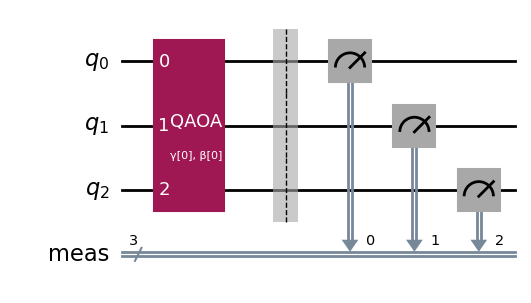

In [12]:
from qiskit.circuit.library import QAOAAnsatz
reps = 1
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps)
circuit.measure_all()

circuit.draw('mpl')

In [13]:
circuit.num_parameters

2

In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
#AerSimulator
from qiskit_aer import AerSimulator

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
from qiskit_ibm_runtime import QiskitRuntimeService
 
# QiskitRuntimeService.save_account(
#   token="36d68aac6ec2fa23a6cc3da232ae7e0e579d4f0125eb5feda65ec8f633c4e682328b1c72ae69dcbae910b40c98df7a11366289bad70db6157fabedd5336adc2f",
#  channel="ibm_quantum" # `channel` distinguishes between different account types
# )

# Load saved credentials
service = QiskitRuntimeService(name='ananduNTHU')

#backend = service.least_busy(min_num_qubits=127)
backend = AerSimulator()

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=1,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
#candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [15]:
def create_init_params(reps, gamma=np.pi, beta=np.pi/2):
    """
    Create initialization parameters for quantum circuit.
    
    Args:
        reps (int): Number of repetitions
        gamma (float): Initial gamma value (default: π)
        beta (float): Initial beta value (default: π/2)
    
    Returns:
        list: List of alternating gamma and beta values
    """
    return [gamma, beta] * reps
init_params = create_init_params(reps)

In [16]:
print(len(init_params))

2


In [17]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [18]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-3,
        options={'rhobeg': 4, "maxiter": 1000}
    )
    print(res)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 8.065761869034588
       x: [-4.969e-01  6.404e-01]
    nfev: 32
   maxcv: 0.0


In [19]:
res.x

array([-0.49693686,  0.64044045])

The optimizer was able to reduce the cost and find better parameters for the circuit.


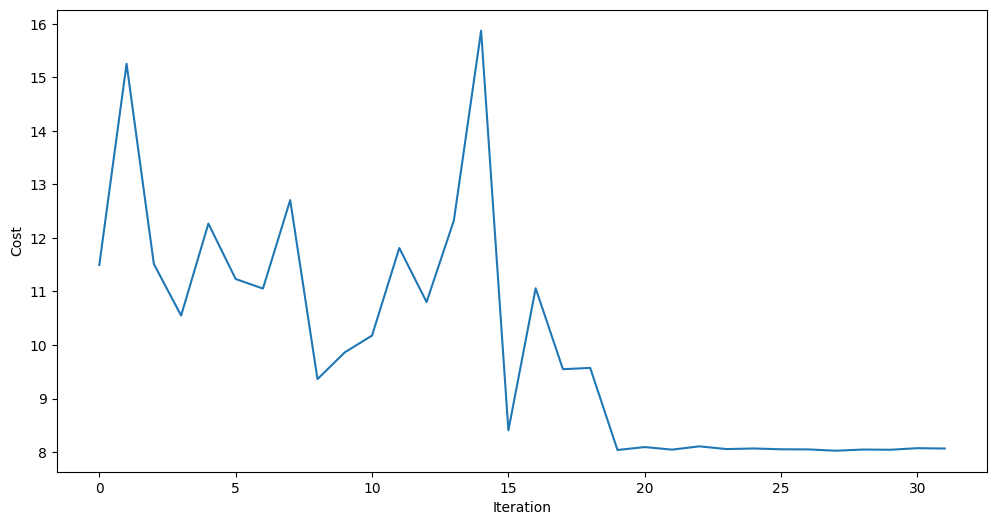

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [21]:
optimized_circuit = candidate_circuit.assign_parameters(res.x)
#optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [22]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 1000

# Set simple error suppression/mitigation options
#sampler.options.dynamical_decoupling.enable = True
#sampler.options.dynamical_decoupling.sequence_type = "XY4"
#sampler.options.twirling.enable_gates = True
#sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
#print(final_distribution_int)

In [23]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, cost_hamiltonian.num_qubits)

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 1]


In [24]:
# Sort the dictionary items by values in descending order
sorted_items = sorted(counts_bin.items(), key=lambda x: x[1], reverse=True)
# Display the sorted key-value pairs
for key, value in sorted_items:
    print(f'{key}: {value}')

101: 2628
000: 2491
010: 2141
100: 2002
001: 244
011: 222
111: 219
110: 53
